## Domain-Adversarial-Neural-Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf

In [3]:
import numpy as np

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Dropout

import os
import shutil
import sys
import matplotlib.pyplot as plt
import h5py
from IPython.display import Image

### Domain Adaptation

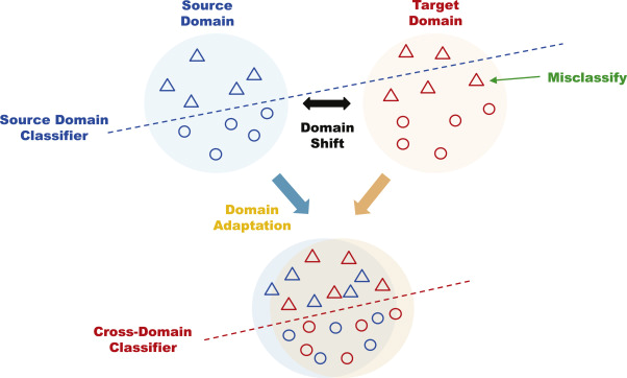

In [4]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/da.png')

* Fine tuning

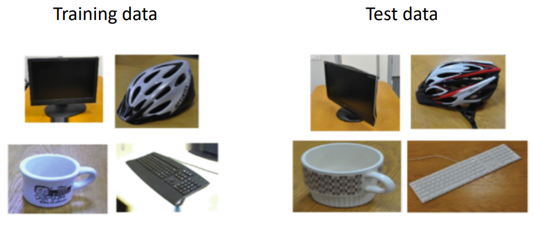

In [5]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/svr.png')

* Domain Adaptation

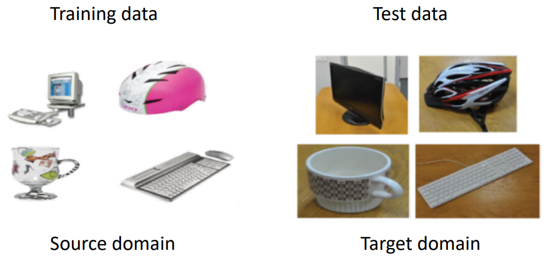

In [6]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/ds.png')

In [7]:
MNIST_M_PATH = '/content/drive/MyDrive/CDS2(2022-2)/DA_data/mnistm.h5'

BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 30

* Data Load

In [8]:
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
mnist_train_x, mnist_test_x = mnist_train_x.reshape((60000, 28, 28, 1)), mnist_test_x.reshape((10000, 28, 28, 1))
# 3-channel로 변경하기 위해서 차원을 늘려준다.

* scaliling

In [10]:
mnist_train_x, mnist_test_x = mnist_train_x / 255.0, mnist_test_x / 255.0
# 0~1사이로 변환
mnist_train_x, mnist_test_x = mnist_train_x.astype('float32'), mnist_test_x.astype('float32')
# float 형식으로 변환

In [11]:
mnist_train_x = np.repeat(mnist_train_x, CHANNELS, axis=3)
# 배열을 반복하여 3-channel로 변경
mnist_test_x = np.repeat(mnist_test_x, CHANNELS, axis=3)
# 배열을 반복하여 3-channel로 변경

In [12]:
mnist_train_y = tf.one_hot(mnist_train_y, depth=10)
# [1, 0.... 0,, 0] 형태로 변경
mnist_test_y = tf.one_hot(mnist_test_y, depth=10)
# [1, 0.... 0,, 0] 형태로 변경

In [13]:
assert(mnist_train_x.shape == (60000,28,28,3))
assert(mnist_test_x.shape == (10000,28,28,3))
assert(mnist_train_y.shape == (60000,10))
assert(mnist_test_y.shape == (10000,10))
# 데이터의 shape이 내가 원하는 데로 잘 적용되었는지 확인

In [14]:
# assert(mnist_test_y.shape == (4, 4))
# 위와 같이 제대로 안맞으면 에러 발행

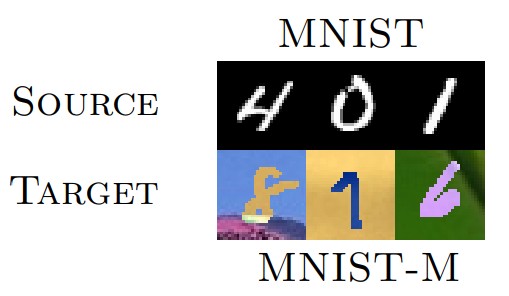

In [15]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/mm.png')

* MNIST 시각화 : Source Domain

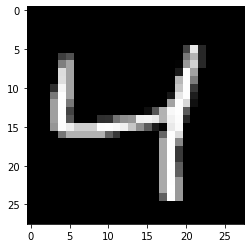

In [16]:
plt.imshow(mnist_train_x[2])

* MNIST-M 시각화 : Target Domain 

In [17]:
with h5py.File(MNIST_M_PATH, 'r') as mnist_m:
    mnist_m_train_x, mnist_m_test_x = mnist_m['train']['X'][()], mnist_m['test']['X'][()]
# 사전에 정의되어있는 MNIST_M Dataset 읽어오기

mnist_m_train_x, mnist_m_test_x = mnist_m_train_x / 255.0, mnist_m_test_x / 255.0
mnist_m_train_x, mnist_m_test_x = mnist_m_train_x.astype('float32'), mnist_m_test_x.astype('float32')

mnist_m_train_y, mnist_m_test_y = mnist_train_y, mnist_test_y

# MNIST와 동일하게 처리

assert(mnist_m_train_x.shape == (60000,28,28,3))
assert(mnist_m_test_x.shape == (10000,28,28,3))
assert(mnist_m_train_y.shape == (60000,10))
assert(mnist_m_test_y.shape == (10000,10))
# 형식이 맞는지 확인

* MNIST_M 시각화 : Target Domain

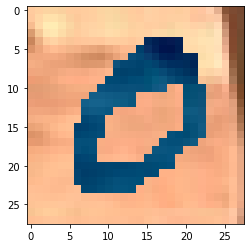

In [20]:
plt.imshow(mnist_m_train_x[1])

* Data Preprocessing

In [21]:
source_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_x, mnist_train_y)).shuffle(1000).batch(BATCH_SIZE*2)
da_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_x, mnist_train_y, mnist_m_train_x, mnist_m_train_y)).shuffle(1000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((mnist_m_test_x, mnist_m_test_y)).shuffle(1000).batch(BATCH_SIZE*2) 
test_dataset2 = tf.data.Dataset.from_tensor_slices((mnist_m_train_x, mnist_m_train_y)).shuffle(1000).batch(BATCH_SIZE*2) 
# 각 데이터가 모델의 input으로 들어갈 수 있도록 batch 단위로 분할

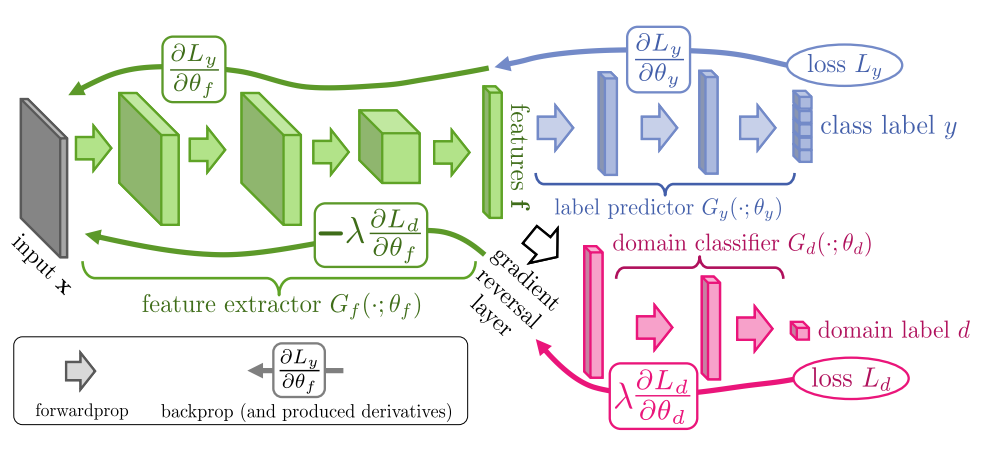

In [22]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/dann.png')

### Gradient Reversal Layer

In [23]:
@tf.custom_gradient
# 내가 만들고 싶은 형식으로 gradient를 만들겠다.
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
        # gradient를 -를 곱하여 전파하겠다.
    
    return y, grad
    # y와 function을 출력

In [24]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)

### Model Architecture

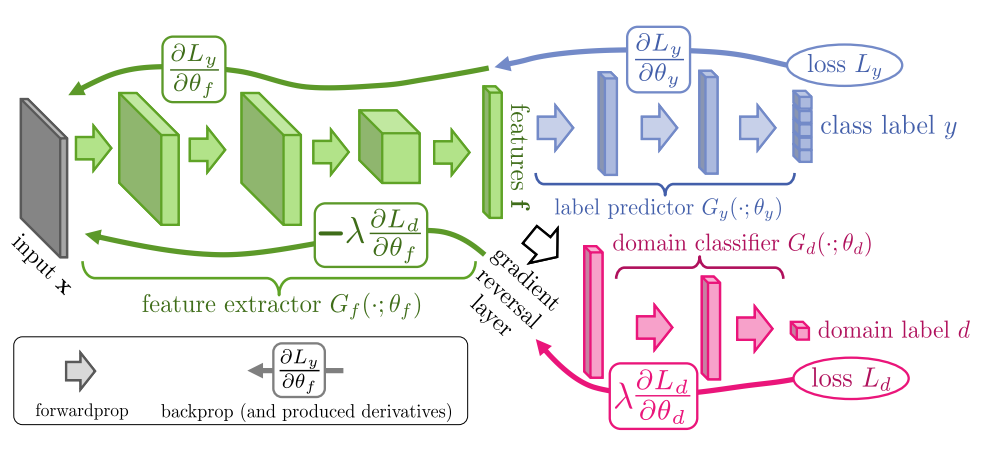

In [25]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/dann.png')

In [26]:
class DANN(Model):
    def __init__(self):
        super().__init__()
        
        self.feature_extractor_layer0 = Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.feature_extractor_layer1 = BatchNormalization()
        self.feature_extractor_layer2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        
        self.feature_extractor_layer3 = Conv2D(64, kernel_size=(5, 5), activation='relu')
        self.feature_extractor_layer4 = Dropout(0.5)
        self.feature_extractor_layer5 = BatchNormalization()
        self.feature_extractor_layer6 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        # 이미지의 feature를 학습하는 부분
        

        self.label_predictor_layer0 = Dense(100, activation='relu')
        self.label_predictor_layer1 = Dense(100, activation='relu')
        self.label_predictor_layer2 = Dense(10, activation=None)
        # label을 분류하는 부분
        

        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(100, activation='relu')
        self.domain_predictor_layer2 = Dense(2, activation=None)
        # domain을 구분하는 부분
        
    def call(self, x, train=False, source_train=True, lamda=1.0):
        # source_train=True
        # 
        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x, training=train)
        x = self.feature_extractor_layer2(x)
        
        x = self.feature_extractor_layer3(x)
        x = self.feature_extractor_layer4(x, training=train)
        x = self.feature_extractor_layer5(x, training=train)
        x = self.feature_extractor_layer6(x)
        
        feature = tf.reshape(x, [-1, 4 * 4 * 64])
        
        # 경우에 따라 feature_slice 구분
        if source_train is True:
            feature_slice = feature
            # source train이 True인 경우엔 위의 feature를 그대로 가져온다.

        else:
          # 아닌 경우
            feature_slice = tf.slice(feature, [0, 0], [feature.shape[0] // 2, -1])
            # 원본 feature의 [0, 0] 위치에서 [feature.shape[0] // 2, -1] 만큼 가져오기
            print(feature_slice)

        lp_x = self.label_predictor_layer0(feature_slice)
        # feature extractor를 통과한 feature map을 
        lp_x = self.label_predictor_layer1(lp_x)
        # 예측 layer에 넣어서 label 예측
        l_logits = self.label_predictor_layer2(lp_x)
        
        #Domain 예측
        if source_train is True:
            return l_logits
            # source train이 True인 경우는 위와 같이 출력

        else:
          # 아닌 경우는 domain class를 예측하고 reverse gradient로 학습
            dp_x = self.domain_predictor_layer0(feature, lamda)
            # GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            # domain classification
            d_logits = self.domain_predictor_layer2(dp_x)
            
            return l_logits, d_logits
            # label 예측과, domain 예측

* Model define

In [27]:
model = DANN()
# 모델 정의

* Loss

In [28]:
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))
    # crossentropy loss


def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
        # label에 대한 loss만 계산
    else:
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)
        # label에 대한 loss와 domain에 대한 loss 둘다 계산

* Optimizer

In [29]:
model_optimizer = tf.optimizers.SGD()
# optimizer 정의

* Domain Label

In [30]:
domain_labels = np.vstack([np.tile([1., 0.], [BATCH_SIZE, 1]),
                           np.tile([0., 1.], [BATCH_SIZE, 1])])
# 세로로 결합하는데 source는 [1,0], target은 [0, 1]이 되도록 결합

domain_labels = domain_labels.astype('float32')

* Accuracy 기록

In [31]:
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
source_acc = []  
da_acc = []      
test_acc = []    
test2_acc = []   

* Source Train Function

In [32]:
@tf.function
# tf1과 같이 사용하겠다. : 속도 향상

def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    # image와 label을 각각 받아온다.

    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        # 모델에 입력하는데 먼저 source로만 훈련하겠다. 즉, label prediction만 하겠다.
        model_loss = get_loss(output, labels)
        # label loss 계산
        epoch_accuracy(output, labels)
        # label accuracy 계산
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    # 실제 값과의 차이를 통해 gradient 역전파
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))
    # optimizer를 통해 업데이트

* Domain train

In [33]:
@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], axis=0)
    # source와 target image를 concat하여 입력받는다.
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        # model에 입력하는데 이때는 domain classification도 함께 학습
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        # label loss와 domain loss를 둘다 계산
        epoch_accuracy(output[0], labels)
        # 정확도 측정

    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    # model의 전체 gradient를 계산
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))
    # 업데이트

In [34]:
@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    # image와 label을 입력

    output = model(images, train=False, source_train=True)
    # 학습하지 않은 상태로 label prediction 만 진행
    epoch_accuracy(output, labels)
    # 정확도 계산

* Total Train Function

In [35]:
def train(train_mode, epochs=EPOCH):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
        # source data로 먼저 label prediction model을 학습한다.

    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
        # source와 target을 둘다 입력하여 label prediction과 domain classification을 둘다 학습한다.

    else:
        raise ValueError("Unknown training Mode")
    

    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        # 람다를 동적으로 조정
        lamda = lamda.astype('float32')

        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        # 정확도 출력
        acc_list.append(epoch_accuracy.result())
        # 정확도 입력
        test()
        # test 진행
        epoch_accuracy.reset_states()
        # 정확도 입력

In [36]:
def test():
    epoch_accuracy.reset_states()
    
    #Testing Dataset (Target Domain)
    for batch in test_dataset:
      # source, target 둘다 존재하는 dataset
        test_step(*batch)
        
    print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    
    for batch in test_dataset2:
        test_step(*batch)
    
    print("Target Domain Accuracy : {:.3%}".format(epoch_accuracy.result()))
    test2_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    # 두번 test

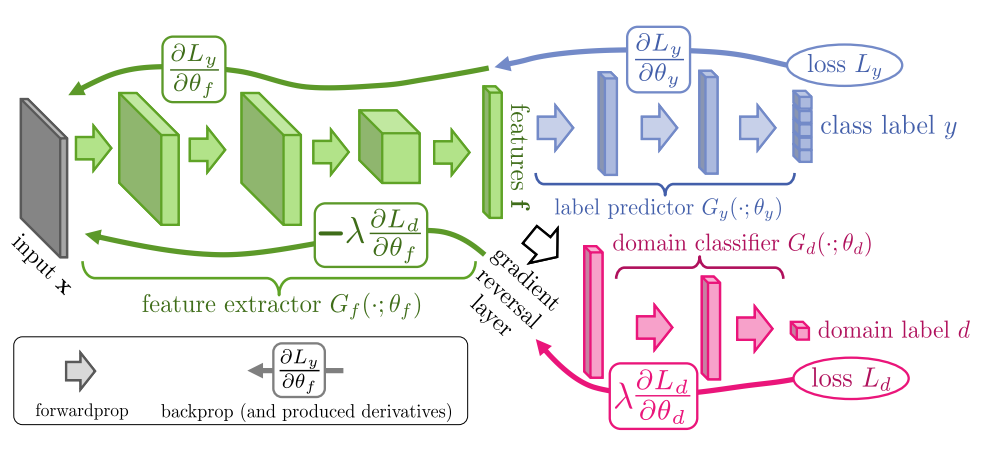

In [37]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/10/dann.png')

In [38]:
train('source', 10)

Training: Epoch 0 :	 Source Accuracy : 93.132%  |  Testing Accuracy : 41.730%  |  Target Domain Accuracy : 41.217%
Training: Epoch 1 :	 Source Accuracy : 97.405%  |  Testing Accuracy : 43.550%  |  Target Domain Accuracy : 43.312%
Training: Epoch 2 :	 Source Accuracy : 97.977%  |  Testing Accuracy : 44.020%  |  Target Domain Accuracy : 43.575%
Training: Epoch 3 :	 Source Accuracy : 98.353%  |  Testing Accuracy : 44.550%  |  Target Domain Accuracy : 43.855%
Training: Epoch 4 :	 Source Accuracy : 98.550%  |  Testing Accuracy : 43.280%  |  Target Domain Accuracy : 42.895%
Training: Epoch 5 :	 Source Accuracy : 98.742%  |  Testing Accuracy : 43.610%  |  Target Domain Accuracy : 43.135%
Training: Epoch 6 :	 Source Accuracy : 98.815%  |  Testing Accuracy : 42.920%  |  Target Domain Accuracy : 42.438%
Training: Epoch 7 :	 Source Accuracy : 98.930%  |  Testing Accuracy : 42.870%  |  Target Domain Accuracy : 42.188%
Training: Epoch 8 :	 Source Accuracy : 99.030%  |  Testing Accuracy : 43.790%  |

In [39]:
train('domain-adaptation', EPOCH)

Tensor("dann/Slice:0", shape=(32, 1024), dtype=float32)
Tensor("dann/Slice:0", shape=(32, 1024), dtype=float32)
Training: Epoch 0 :	 Source Accuracy : 98.827%  |  Testing Accuracy : 49.940%  |  Target Domain Accuracy : 49.858%
Training: Epoch 1 :	 Source Accuracy : 96.765%  |  Testing Accuracy : 62.310%  |  Target Domain Accuracy : 62.603%
Training: Epoch 2 :	 Source Accuracy : 96.367%  |  Testing Accuracy : 70.630%  |  Target Domain Accuracy : 70.277%
Training: Epoch 3 :	 Source Accuracy : 97.112%  |  Testing Accuracy : 72.810%  |  Target Domain Accuracy : 72.652%
Training: Epoch 4 :	 Source Accuracy : 97.358%  |  Testing Accuracy : 73.990%  |  Target Domain Accuracy : 73.982%
Training: Epoch 5 :	 Source Accuracy : 97.615%  |  Testing Accuracy : 73.440%  |  Target Domain Accuracy : 73.523%
Training: Epoch 6 :	 Source Accuracy : 97.532%  |  Testing Accuracy : 77.130%  |  Target Domain Accuracy : 77.045%
Training: Epoch 7 :	 Source Accuracy : 97.623%  |  Testing Accuracy : 72.790%  |  T

In [40]:
source_acc
# source만 training

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9313167>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97405>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97976667>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9835333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9855>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9874167>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98815>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9893>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9903>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.991>]

In [41]:
da_acc
# DA 동시에 training

[<tf.Tensor: shape=(), dtype=float32, numpy=0.98826665>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96765>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9636667>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97111666>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97358334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97615>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97531664>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9762333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9766>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97795>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97783333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.979>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97931665>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9798833>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97928333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97945>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98015>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97866666>,
 

In [42]:
up_line = source_acc + da_acc

In [46]:
len(up_line)

40

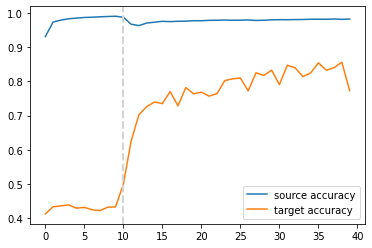

In [48]:
x_axis = [i for i in range(0, 40)]

plt.plot(x_axis, up_line, label="source accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.axvline(10, 0.0, 1.0, color='lightgray', linestyle='--', linewidth=2)
plt.legend()